In [1]:
import argparse
from state import State
from data_loader import load_data
from agent import Agent
from attention import Attention
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from evaluate import computeF1, evaluate
import math
import random

class ReactiveBaseline():
    def __init__(self, l):
        self.l = l
        self.b = 0.0
    def get_baseline_value(self):
        return self.b
    def update(self, target):
        self.b = (1-self.l)*self.b + self.l*target


GAMMA = 1
WORD_EMB_DIM = 94
NODE_EMB_DIM = 30
H_DIM = 64
T = 3
NUM_EPOCH = 1000
SOFT_REWARD_SCALE = 0.1
NUM_ROLL_OUT = 1
SHUFFLE = False

# device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# arguemnt parsing
# load dataset
node_embedding, rel_embedding, kg, train, test = load_data("countries", WORD_EMB_DIM, "ComplEX")


# projection from word embedding to node node embedding
word2node = nn.Linear(WORD_EMB_DIM, NODE_EMB_DIM, bias=False).to(device)

# mutihead self-attention
attention = Attention(4, NODE_EMB_DIM, H_DIM, math.sqrt(H_DIM)).to(device)

# list contains all params that need to optimize
model_param_list = list(word2node.parameters()) + list(attention.parameters())

# init agent
state = State((train[0][1],train[0][2]), kg, node_embedding, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device) # init here to calculate the input size
input_dim = state.get_input_size()
num_rel = len(kg.rel_vocab)
num_entity = len(kg.en_vocab)
num_subgraph = len(state.subgraphs)
emb_dim = WORD_EMB_DIM + NODE_EMB_DIM
baseline = ReactiveBaseline(l = 0.02)
agent = Agent(input_dim, 32, emb_dim, 0, 2, num_entity, num_rel,num_subgraph, GAMMA, 0.00005, model_param_list, baseline, device)

# training loop
index_list = list(range(len(train)))
acc = 0
for epoch in range(NUM_EPOCH):
    losses = []
    rewards = []
    correct = 0
    true_positive = 0
    
    f1 = []
    if SHUFFLE:
        random.shuffle(index_list)
    for n in tqdm(range(len(train))):
        # create state from the question
        i = index_list[n]
        for _ in range(NUM_ROLL_OUT):
            state = State((train[i][1],train[i][2]), kg, node_embedding, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device)
            answers = kg.encode_answers(train[i][0])
            e0 = state.subgraphs[0][0]
            agent.policy.init_path(e0, state)

            # go for T step
            for step in range(T):
                action = agent.get_action(state)
                g, r, e = action
                if step < T-1:
                    agent.hard_reward(0)
                else:
                    nodes = state.get_last_nodes()
                    max_shortest_path = kg.max_shortest_path(nodes)
                    if e in answers and nodes[0] == nodes[1]:
                        correct += 1
                        true_positive += 1
                        if acc >= 0.4:
                            print(i)
                            assert(False)
                        agent.hard_reward(10)
                    elif e in answers:
                        agent.hard_reward(1)
                        correct += 1
                    else:
                        agent.hard_reward(0)
                        #answer_embedding = state.node_embedding[answer]
                        #e_embedding = state.node_embedding[e]
                        #agent.soft_reward(answer_embedding, e_embedding, SOFT_REWARD_SCALE, -max_shortest_path)
                state.update(action)
                #print("step: " + str(step) + ", take action: " + str(action) + "result_subgraphs:" + str(state.subgraphs))

            # update the policy net and record loss
            loss, reward, last_reward = agent.update_policy()
            losses.append(loss)
            rewards.append(reward)

    acc = correct/(NUM_ROLL_OUT*len(train))
    avg_loss = np.mean(losses)
    avg_reward = np.mean(rewards)
    print("epoch: {}, loss: {}, reward: {}, true_positive: {}, acc: {}".format(epoch, avg_loss, avg_reward, true_positive/NUM_ROLL_OUT, acc))

    # evaluate on test set
    if (epoch+1)%100 == 0:
        evaluate(test, agent, kg, T, WORD_EMB_DIM, word2node, attention, rel_embedding, node_embedding, device, 15)

  0%|          | 1/434 [00:00<00:55,  7.87it/s]

epoch: 0, loss: 0.05824245622355817, reward: 0.39400921658986177, true_positive: 0.0, acc: 0.1313364055299539


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 1, loss: -0.1973287242760856, reward: 0.39400921658986177, true_positive: 1.0, acc: 0.11059907834101383


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 2, loss: -0.16343997638621088, reward: 0.5046082949308756, true_positive: 1.0, acc: 0.14746543778801843


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 3, loss: -0.2272577829281306, reward: 0.35944700460829493, true_positive: 0.0, acc: 0.11981566820276497


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 4, loss: -0.044402638373012365, reward: 0.4078341013824885, true_positive: 0.0, acc: 0.1359447004608295


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 5, loss: -0.17416428091339253, reward: 0.6082949308755761, true_positive: 2.0, acc: 0.16129032258064516


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 6, loss: -0.2135460551158624, reward: 0.5668202764976958, true_positive: 1.0, acc: 0.16820276497695852


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 7, loss: -0.3016702124874713, reward: 0.6290322580645161, true_positive: 1.0, acc: 0.1889400921658986


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 8, loss: -0.32801670898696245, reward: 0.6912442396313364, true_positive: 2.0, acc: 0.1889400921658986


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 9, loss: -0.48742252378831813, reward: 0.9193548387096774, true_positive: 5.0, acc: 0.20276497695852536


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 10, loss: -0.5597239822011939, reward: 0.9815668202764977, true_positive: 5.0, acc: 0.22350230414746544


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 11, loss: -0.7059624466684556, reward: 1.3064516129032258, true_positive: 8.0, acc: 0.2695852534562212


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 12, loss: -0.865641239764435, reward: 1.3410138248847927, true_positive: 9.0, acc: 0.26036866359447003


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 13, loss: -0.7748336076054052, reward: 1.4377880184331797, true_positive: 10.0, acc: 0.271889400921659


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 14, loss: -0.8266785272583794, reward: 1.5, true_positive: 9.0, acc: 0.31336405529953915


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 15, loss: -0.6711996359287113, reward: 1.5345622119815667, true_positive: 11.0, acc: 0.2834101382488479


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 16, loss: -0.7589495946623145, reward: 1.4792626728110598, true_positive: 9.0, acc: 0.3064516129032258


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 17, loss: -0.7516425506915674, reward: 1.444700460829493, true_positive: 9.0, acc: 0.29493087557603687


  0%|          | 0/434 [00:00<?, ?it/s]

epoch: 18, loss: -0.6146871195161878, reward: 1.5138248847926268, true_positive: 9.0, acc: 0.31797235023041476


 49%|████▉     | 212/434 [00:49<00:53,  4.17it/s]

KeyboardInterrupt: 

153


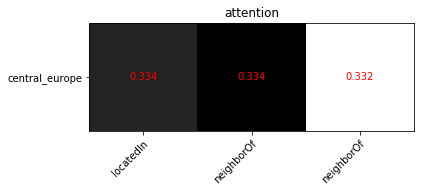

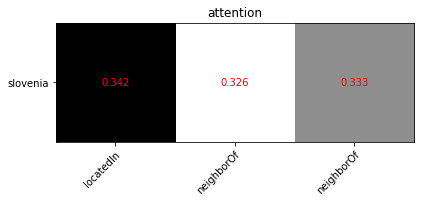

[['central_europe'], ['slovenia']]
1 neighborOf austria


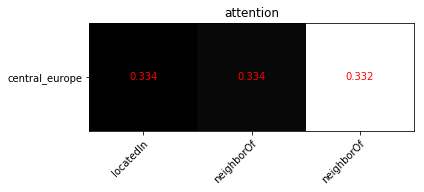

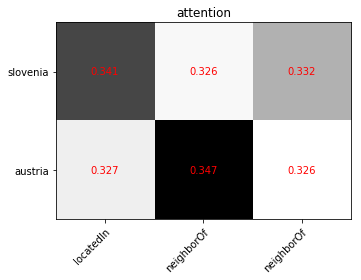

[['central_europe'], ['slovenia', 'austria']]
1 neighborOf slovakia


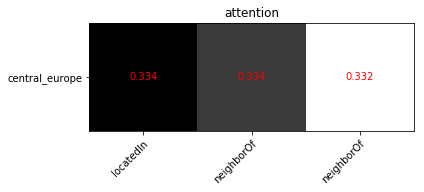

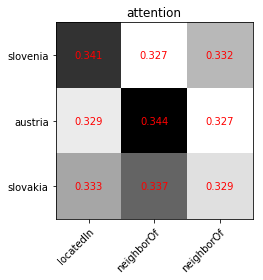

[['central_europe'], ['slovenia', 'austria', 'slovakia']]
0 locatedIn slovakia
slovakia
slovakia
[['central_europe', 'slovakia'], ['slovenia', 'austria', 'slovakia']]


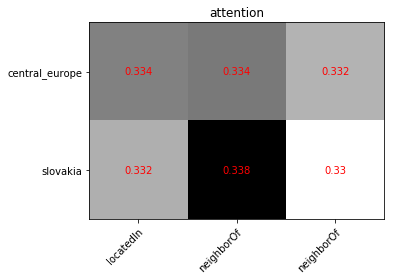

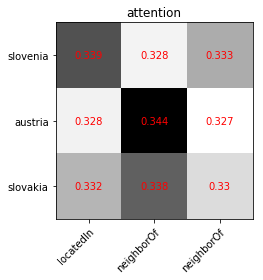

['slovakia']
predicted: slovakia


In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# select the question you want to visualize
question_number = 1

def find_ename(e):
    for e_name in state.graph.en_vocab:
        if state.graph.en_vocab[e_name] == e:
            return e_name
        
def find_rname(r):
    for r_name in state.graph.rel_vocab:
        if state.graph.rel_vocab[r_name] == r:
            return r_name
            

def print_attention():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_Rt = F.softmax(L, dim=1)
            graph = 1 - A_Rt
            
            fig, ax = plt.subplots()
            im = ax.imshow(graph,cmap='gray')
            ax.set_xticks(np.arange(len(rs)))
            ax.set_yticks(np.arange(len(es)))
            ax.set_xticklabels(rs)
            ax.set_yticklabels(es)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(es)):
                for j in range(len(rs)):
                    text = ax.text(j, i, round(A_Rt[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

def print_Agti():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            if find_rname(r) not in rs:
                rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_gti = F.softmax(torch.t(L), dim=1)
            graph = 1 - A_gti
            
            fig, ax = plt.subplots()
            im = ax.imshow(graph,cmap='gray')
            ax.set_xticks(np.arange(len(es)))
            ax.set_yticks(np.arange(len(rs)))
            ax.set_xticklabels(es)
            ax.set_yticklabels(rs)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(rs)):
                for j in range(len(es)):
                    text = ax.text(j, i, round(A_gti[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

for question_number in [153]:
    print(question_number)
    state = State((train[question_number][1],train[question_number][2]), kg, node_embedding, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device)
    ans_word = []
    for a in train[question_number][0]:
        ans_word.append(a)    
    e0 = e0 = state.subgraphs[0][0]
    agent.policy.init_path(e0, state)
    
    # go for T step
    predicted = None
    for step in range(T):
        print_attention()
        text_subgraphs = []
        for subgraph in state.subgraphs:
            temp = []
            for e in subgraph:
                temp.append(find_ename(e))
            text_subgraphs.append(temp)
        print(text_subgraphs)
        embedded_state = state.get_embedded_state()
        possible_actions = state.generate_all_possible_actions()
        action = agent.get_action(state)
        g, r, e = action
        print(g, find_rname(r), find_ename(e))
        
        state.update(action)
        
    nodes = state.get_last_nodes()
    a = len(state.subgraphs[0]) > 1
    b = len(state.subgraphs[1]) > 1
    if nodes[0] == nodes[1] and a and b:
        for e in nodes:
            print(find_ename(e))
        max_shortest_path = kg.max_shortest_path(nodes)
        text_subgraphs = []
        for subgraph in state.subgraphs:
            temp = []
            for e in subgraph:
                temp.append(find_ename(e))
            text_subgraphs.append(temp)
        print(text_subgraphs)
        print_attention()
        print(ans_word)
        print("predicted: " + find_ename(e))
        break
 

Parameter containing:
tensor([[-0.0231,  0.0345, -0.0024,  ...,  0.0043,  0.0059, -0.0285],
        [ 0.0075, -0.0653,  0.0121,  ..., -0.0427, -0.0371, -0.0151],
        [ 0.0130, -0.0058, -0.0467,  ..., -0.0144, -0.0086, -0.0456],
        ...,
        [-0.0249,  0.0097,  0.0436,  ..., -0.0175, -0.0471, -0.0223],
        [-0.0365,  0.0299, -0.0302,  ...,  0.0414,  0.0230, -0.0454],
        [-0.0366,  0.0197, -0.0279,  ..., -0.0101, -0.0358, -0.0059]],
       requires_grad=True)


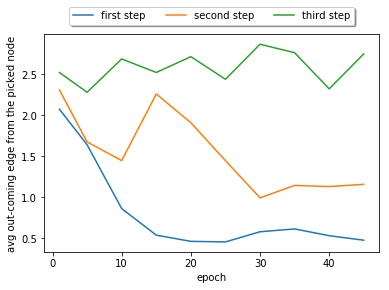

In [42]:
node_1 = [2.075862068965517, 1.6413793103448275, 0.8620689655172413, 0.5379310344827586, 0.46206896551724136, 0.45517241379310347, 0.5793103448275863, 0.6137931034482759, 0.5310344827586206, 0.47586206896551725]
node_2 = [2.310344827586207, 1.6758620689655173, 1.4482758620689655, 2.2620689655172415, 1.910344827586207, 1.4482758620689655, 0.993103448275862, 1.1448275862068966, 1.1310344827586207, 1.1586206896551725]
node_3 = [2.524137931034483, 2.282758620689655, 2.689655172413793, 2.524137931034483, 2.717241379310345, 2.4413793103448276, 2.8689655172413793, 2.7655172413793103, 2.3241379310344827, 2.7517241379310344]
fig, ax = plt.subplots()
x = np.arange(len(node_1))
x = x*5
x[0] += 1
line1 = ax.plot(x, node_1, label="first step")
line2 = ax.plot(x, node_2, label="second step")
line3 = ax.plot(x, node_3, label="third step")
plt.xlabel("epoch")
plt.ylabel("avg out-coming edge from the picked node")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()